In [1]:
import pandas as pd
import seaborn as sns
import pingouin as pg
import sys
import graphviz
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
import os
import folium
import leafmap.foliumap as leafmap

In [6]:
df = pd.read_csv('automation_issue.csv', index_col=None)

In [7]:
m = leafmap.Map(
    location=[29.720947,-95.261923],
    zoom_start=10,
    max_zoom=25
)

fl1 = folium.FeatureGroup('Hard_to_Evaluate').add_to(m)

real_end_lon = df['lon']
real_end_lat = df['lat']
ca_status = df['ca_status']
search_point_lon = df['destination_search_result_point_lon']
search_point_lat = df['destination_search_result_point_lat']

def color_change(ca_status_item):
    if(ca_status_item == 'Hard_to_Evaluate'):
        return('orange')
    else:
        return('green')
        
for search_point_lon_item, search_point_lat_item, ca_status_item, real_end_lon_item, real_end_lat_item in zip(search_point_lon, search_point_lat, ca_status, real_end_lon, real_end_lat):
    if ca_status_item == 'Hard_to_Evaluate':
        locations = [[search_point_lat_item, search_point_lon_item], [real_end_lat_item, real_end_lon_item]]
        folium.PolyLine(
            locations=locations,
            weight=2,
            color="black",
            fill_opacity=0.9
        ).add_to(fl1)

for search_point_lon_item, search_point_lat_item, ca_status_item in zip(search_point_lon, search_point_lat, ca_status):
    if ca_status_item == 'Hard_to_Evaluate':
        locations = [search_point_lat_item, search_point_lon_item]
        if str(search_point_lon_item) == 'nan' or str(search_point_lat_item) == 'nan':
          continue
        locations = [search_point_lat_item, search_point_lon_item] 
        folium.CircleMarker(
        location=locations,
        radius=7,
        color="black",
        weight=0.6,
        fill_color="green",
        fill_opacity=0.8,
        fill=True,
        ).add_to(fl1)

for real_end_lon_item, real_end_lat_item, ca_status_item in zip(real_end_lon, real_end_lat, ca_status):
    if ca_status_item == 'Hard_to_Evaluate':
        if str(real_end_lon_item) == 'nan' or str(real_end_lat_item) == 'nan':
          continue
        locations = [real_end_lat_item, real_end_lon_item]
        folium.CircleMarker(
        location=locations,
        radius=7,
        color="black",
        weight=0.6,
        fill_color=color_change(ca_status_item),
        fill_opacity=0.8,
        fill=True,
        ).add_to(fl1)
legend_dict = {
    "Search point": "green",
    "Hard_to_Evaluate": "orange"
}
m.add_legend(title="Legend Title", legend_dict=legend_dict)
folium.LayerControl().add_to(m)
m

In [8]:
df.head(5)

item_id               created_at                dt_review        lat  \
0        1  2025-01-01 05:29:02.528  2025-01-09 00:00:00.000  33.685112   
1        2  2025-01-01 05:29:29.857  2025-01-03 00:00:00.000  42.627964   
2        3  2025-01-01 05:29:33.868  2025-01-03 00:00:00.000  42.290970   
3        4  2025-01-01 05:34:26.032  2025-01-03 00:00:00.000  34.137737   
4        5  2025-01-01 05:34:55.099  2025-01-03 00:00:00.000  34.044273   

          lon                                       current_tags  \
0 -117.918490  [platform:android, LA, auto:navigation_stopped...   
1  -83.467125  [platform:android, auto:driver-arrived, auto:b...   
2  -83.233810  [auto:build-production, onboarding, DT, Hard_t...   
3 -118.459720  [LA, platform:android, Hard_to Evaluate, onboa...   
4 -118.447044  [auto:navigation_stopped, Hard_to Evaluate, pl...   

  RP_distance_auto arrival_backdoor_auto destination_search_unit_type reason  \
0              NaN                   NaN                          poi  other   
1              NaN                   NaN                          NaN  other   
2              NaN                   NaN                      address  other   
3              NaN                   NaN                          NaN  other   
4              NaN                   NaN                          NaN  other   

   ... original_estimated_duration real_duration gps_trace_duration  \
0  ...                  162.187000       130.959            129.665   
1  ...                  361.367367       576.872            284.294   
2  ...                  361.053316       639.445            356.013   
3  ...                  362.909554        24.234             23.261   
4  ...                  362.106800       219.172            218.840   

  reroute_count request_coordinates destination_search_result_point_rang  \
0             0                 NaN                                  1.0   
1             0                 NaN                                  0.0   
2             0                 NaN                                  NaN   
3             0                 NaN                                  2.0   
4             0                 NaN                                  2.0   

  end_location_deviation_angle routable_point_to_search_road_distance  \
0                    10.377738                                  4.664   
1                    12.700334                                    NaN   
2                   158.465910                                  0.054   
3                    98.938900                                    NaN   
4                   159.880040                                    NaN   

   distance_to_reach_destination_by_road backdoor  
0                                288.752      NaN  
1                                    NaN      NaN  
2                               1269.405      NaN  
3                                    NaN      NaN  
4                                    NaN      NaN  

[5 rows x 41 columns]

In [9]:
categorical_columns = [
    'destination_search_unit_type', 'reason', 'routable_point', 'feature_type', 'tag_group', 'issue',
    'related_nav_feedbacks', 'destination_search_result_point_accuracy_type', 'trip_type', 'RP', 'finish_tag'
]

for col in categorical_columns:
    df[col] = pd.factorize(df[col])[0] + 1

df['ca_status_index'] = pd.factorize(df['ca_status'])[0]+1

In [10]:
df = pd.get_dummies(df, columns=['RP_distance_auto', 'arrival_backdoor_auto', 'auto_good_tag', 
                                'request_coordinates', 'backdoor'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9003 entries, 0 to 9002
Data columns (total 42 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   item_id                                        9003 non-null   int64  
 1   created_at                                     9003 non-null   object 
 2   dt_review                                      9003 non-null   object 
 3   lat                                            9003 non-null   float64
 4   lon                                            9003 non-null   float64
 5   current_tags                                   9003 non-null   object 
 6   destination_search_unit_type                   9003 non-null   int64  
 7   reason                                         9003 non-null   int64  
 8   routable_point                                 9003 non-null   int64  
 9   feature_type                                   9003 

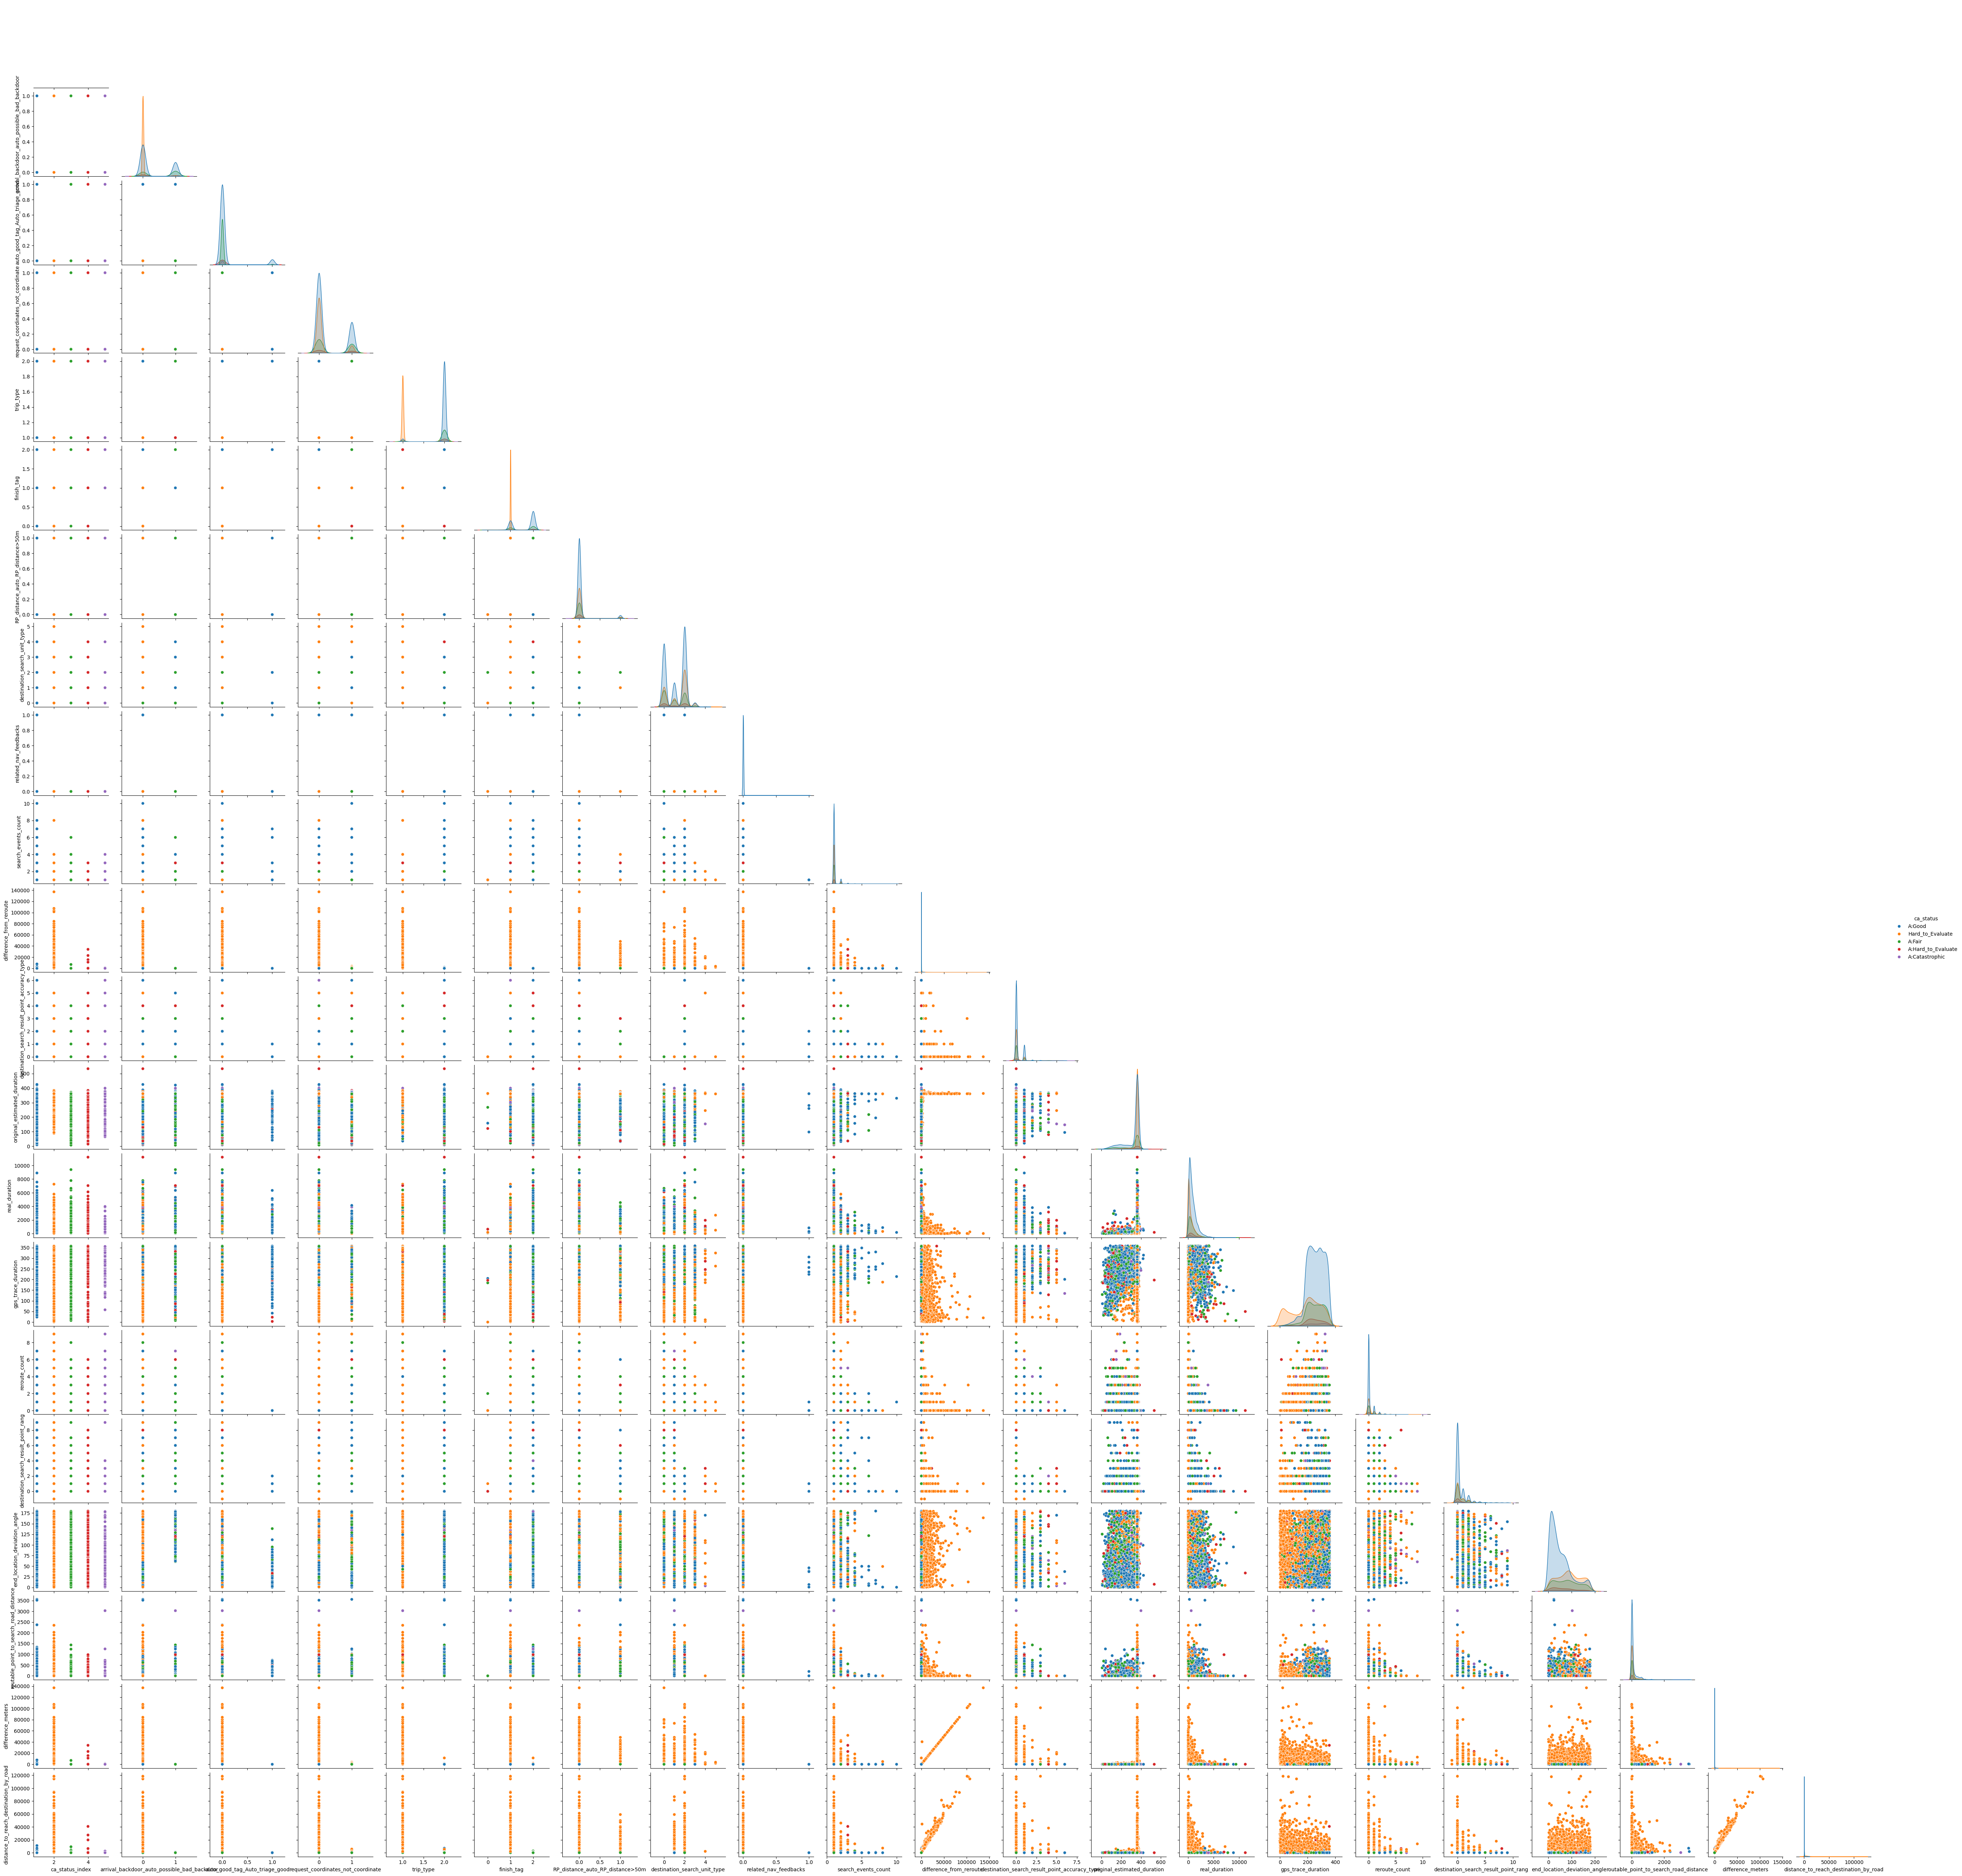

In [30]:
img_png = sns.pairplot(df, hue='ca_status', vars = ['ca_status_index', 'arrival_backdoor_auto_possible_bad_backdoor', 'auto_good_tag_Auto_triage_good',
                       'request_coordinates_not_coordinate', 'trip_type',  'finish_tag', 'RP_distance_auto_RP_distance>50m',
                       'destination_search_unit_type', 'related_nav_feedbacks', 'search_events_count', 'difference_from_reroute', 'destination_search_result_point_accuracy_type',
                       'original_estimated_duration', 'real_duration', 'gps_trace_duration', 'reroute_count', 
                       'destination_search_result_point_rang', 'end_location_deviation_angle', 'routable_point_to_search_road_distance',
                       'difference_meters', 'distance_to_reach_destination_by_road']
                      , corner=True);

In [31]:
img_png.savefig('output.png')

In [33]:
hm = df.drop(columns=['difference_meters', 'routable_point', 'issue', 'item_id', 'created_at', 'dt_review', 'current_tags', 
                     'destination_search_result_point_name', 'destination_search_result_point_category', 
                     'dt_c', 'golden_city', 'current_status', 'tag_group', 'trip_type', 'reason', 'feature_type', 'RP',
                     'distance_to_reach_destination_by_road', 'destination_search_result_point_lat', 'destination_search_result_point_lon',
                     'lat', 'lon'])

<Axes: >

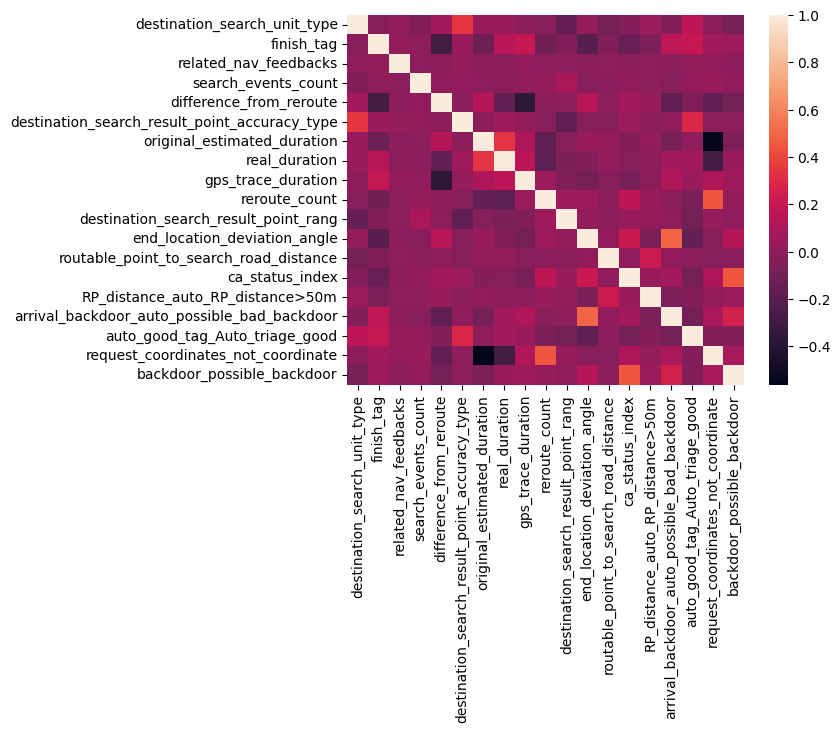

In [34]:
sns.heatmap(hm.corr(numeric_only=True))

In [55]:
df = pd.read_csv('automation_issue.csv', index_col=None)

categorical_columns = [
    'destination_search_unit_type', 
    'related_nav_feedbacks', 'destination_search_result_point_accuracy_type',
    'finish_tag'
]

for col in categorical_columns:
    df[col] = pd.factorize(df[col])[0] + 1

df = pd.get_dummies(df, columns=['RP_distance_auto', 'arrival_backdoor_auto', 'auto_good_tag', 
                                'request_coordinates'])

# целевая переменная
y = df['ca_status']

X = df.drop(columns=['difference_meters', 'routable_point', 'issue', 'ca_status', 'item_id', 'created_at', 'dt_review', 'current_tags', 
                     'destination_search_result_point_name', 'destination_search_result_point_category', 
                     'dt_c', 'golden_city', 'current_status', 'tag_group', 'trip_type', 'reason', 'feature_type', 'RP', 'backdoor',
                    'distance_to_reach_destination_by_road', 'destination_search_result_point_lat', 'destination_search_result_point_lon',
                     'lat', 'lon'])

X = X.fillna(X.mean())

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Обучение дерева решений
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)  
tree_clf.fit(X_train, y_train)  

y_pred_tree = tree_clf.predict(X_test)

# Оценка модели
print("Дерево решений - качественные характеристики:")
print(classification_report(y_test, y_pred_tree, zero_division=0))
print(f"Точность: {accuracy_score(y_test, y_pred_tree):.3f}")

Дерево решений - качественные характеристики:
                    precision    recall  f1-score   support

    A:Catastrophic       0.00      0.00      0.00        25
            A:Fair       0.00      0.00      0.00       276
            A:Good       0.73      0.96      0.83       972
A:Hard_to_Evaluate       0.00      0.00      0.00        67
  Hard_to_Evaluate       0.87      0.99      0.92       461

          accuracy                           0.77      1801
         macro avg       0.32      0.39      0.35      1801
      weighted avg       0.62      0.77      0.68      1801

Точность: 0.771


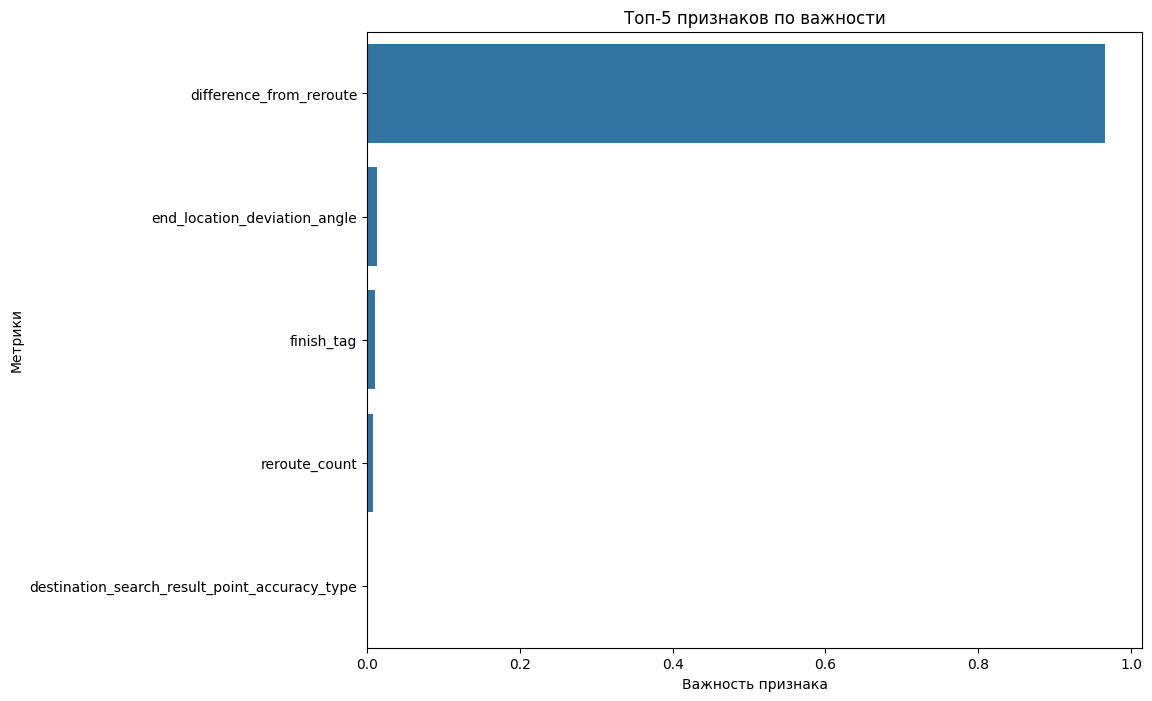

In [62]:
# Важность признаков
feature_importance_tree = pd.DataFrame({
    'Метрики': X.columns,
    'Важность': tree_clf.feature_importances_
})
feature_importance_tree = feature_importance_tree.sort_values(by='Важность', ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_tree.head(5), x='Важность', y='Метрики')
plt.title('Топ-5 признаков по важности')
plt.xlabel('Важность признака')
plt.savefig('tree_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
dot_data = export_graphviz(tree_clf, out_file=None, feature_names=X.columns, class_names=tree_clf.classes_,
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='png', cleanup=True)

'decision_tree.png'

In [65]:
# Обучение леса
forest_clf = RandomForestClassifier(max_depth=5, random_state=42)  
forest_clf.fit(X_train, y_train)  

y_pred_forest = forest_clf.predict(X_test)

# Оценка модели
print("Лес случайностей - качественные характеристики:")
print(classification_report(y_test, y_pred_forest, zero_division=0))
print(f"Точность: {accuracy_score(y_test, y_pred_forest):.3f}")

Лес случайностей - качественные характеристики:
                    precision    recall  f1-score   support

    A:Catastrophic       0.00      0.00      0.00        25
            A:Fair       0.67      0.01      0.01       276
            A:Good       0.72      0.98      0.83       972
A:Hard_to_Evaluate       0.00      0.00      0.00        67
  Hard_to_Evaluate       0.92      0.95      0.94       461

          accuracy                           0.77      1801
         macro avg       0.46      0.39      0.36      1801
      weighted avg       0.73      0.77      0.69      1801

Точность: 0.773


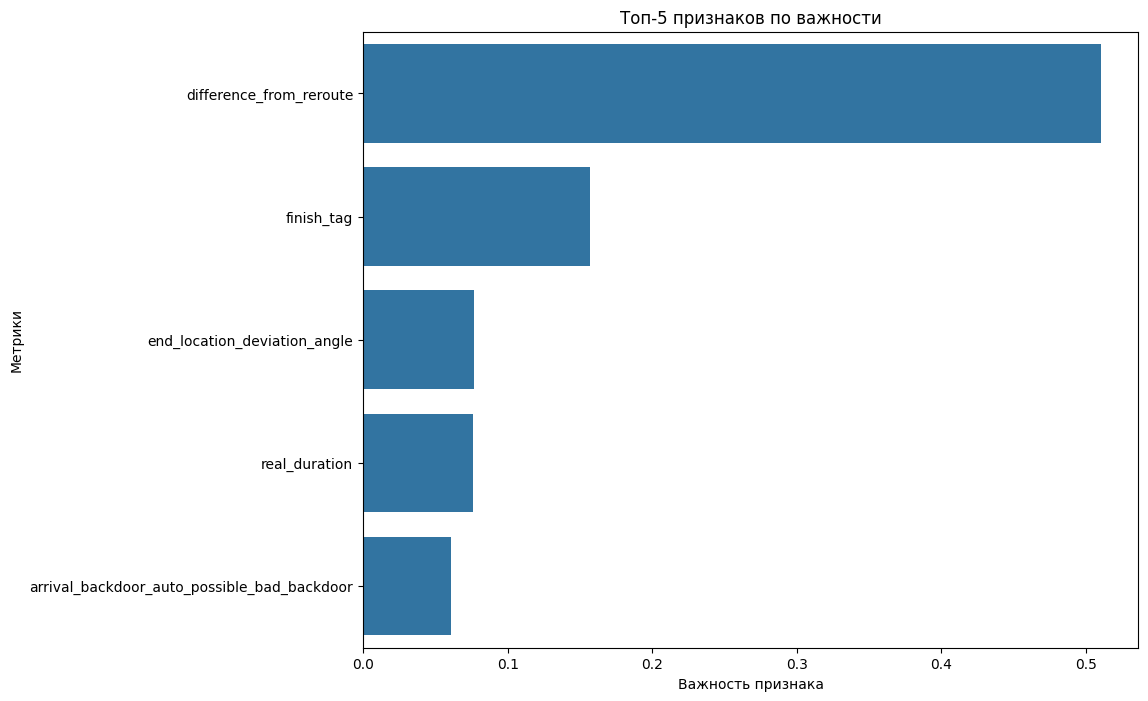

In [66]:
# Важность признаков
feature_importance_forest = pd.DataFrame({
    'Метрики': X.columns,
    'Важность': forest_clf.feature_importances_
})
feature_importance_forest = feature_importance_forest.sort_values(by='Важность', ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_forest.head(5), x='Важность', y='Метрики')
plt.title('Топ-5 признаков по важности')
plt.xlabel('Важность признака')
plt.savefig('feature_importance_forest.png', dpi=300, bbox_inches='tight')
plt.show()

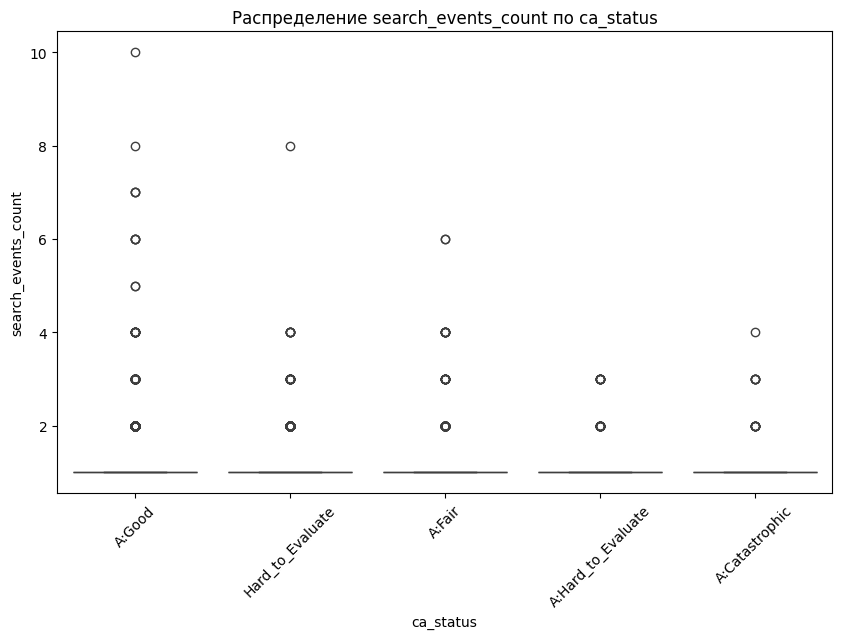

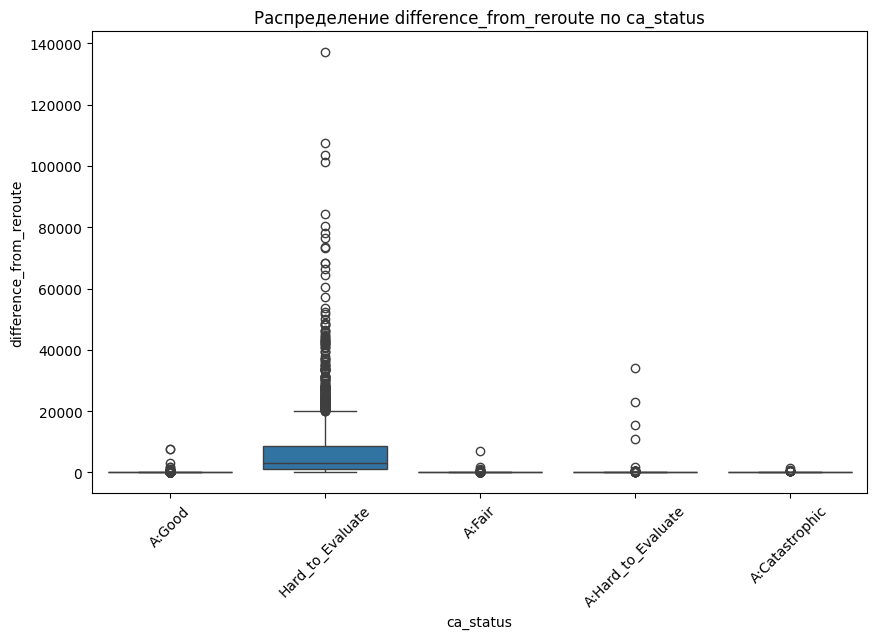

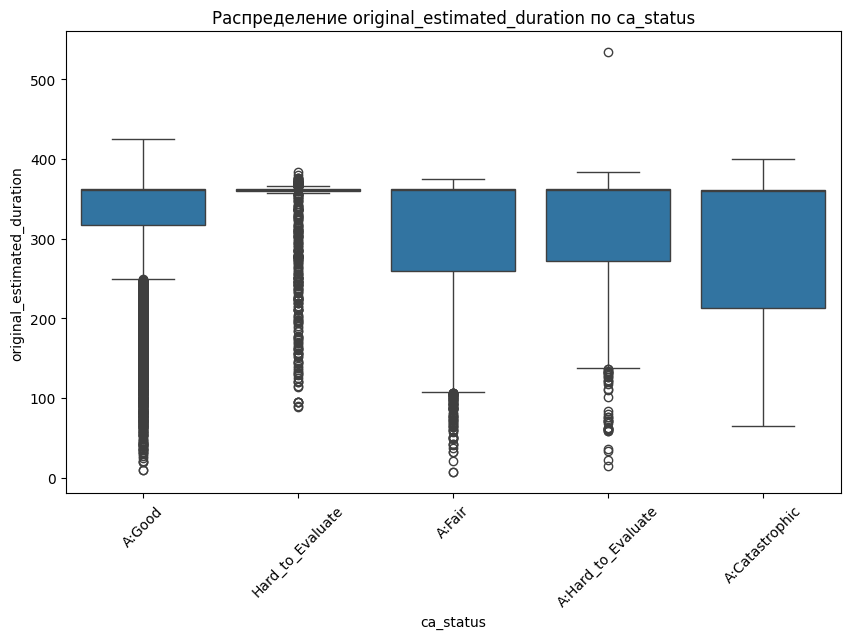

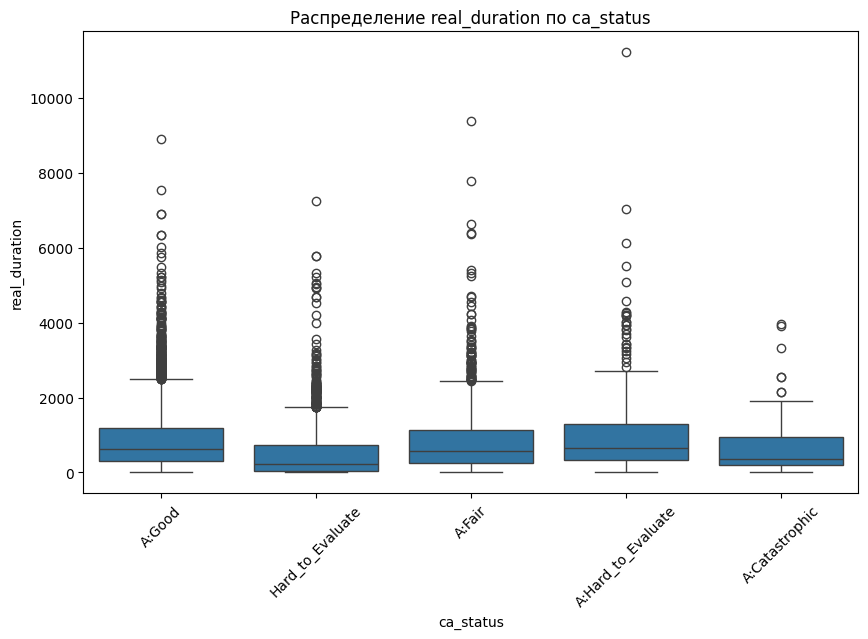

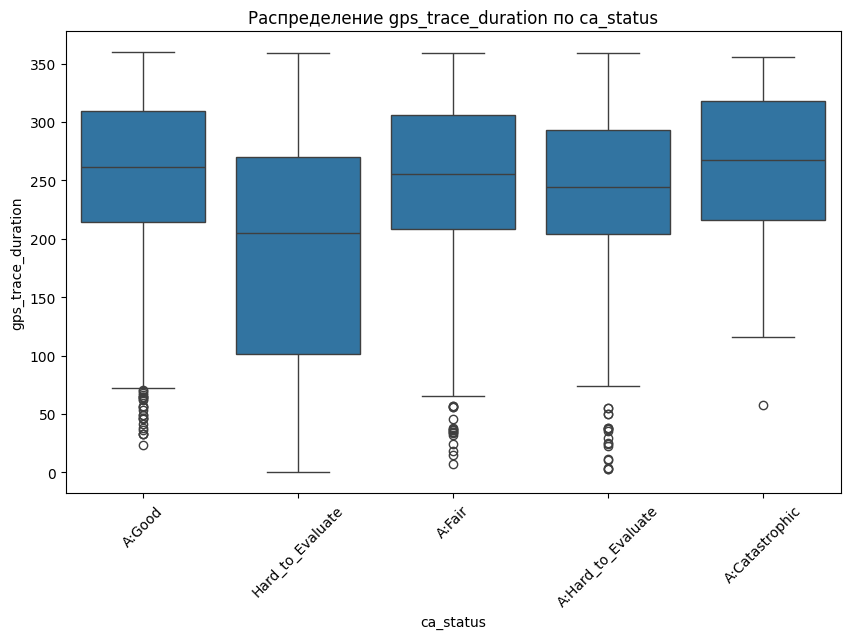

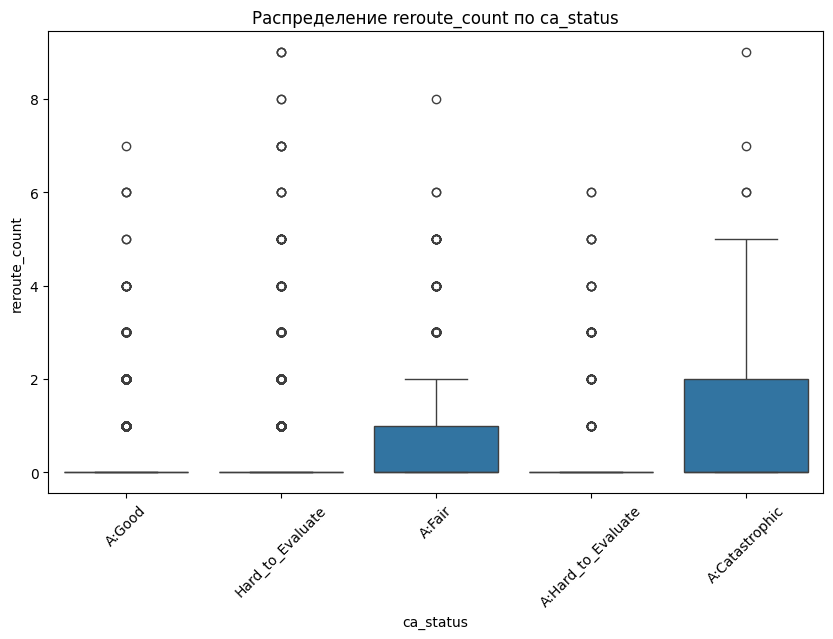

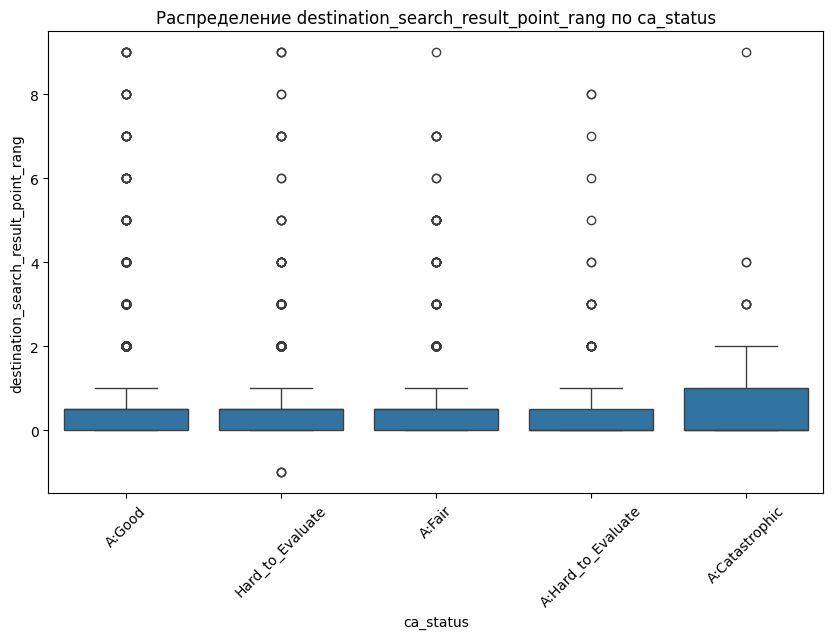

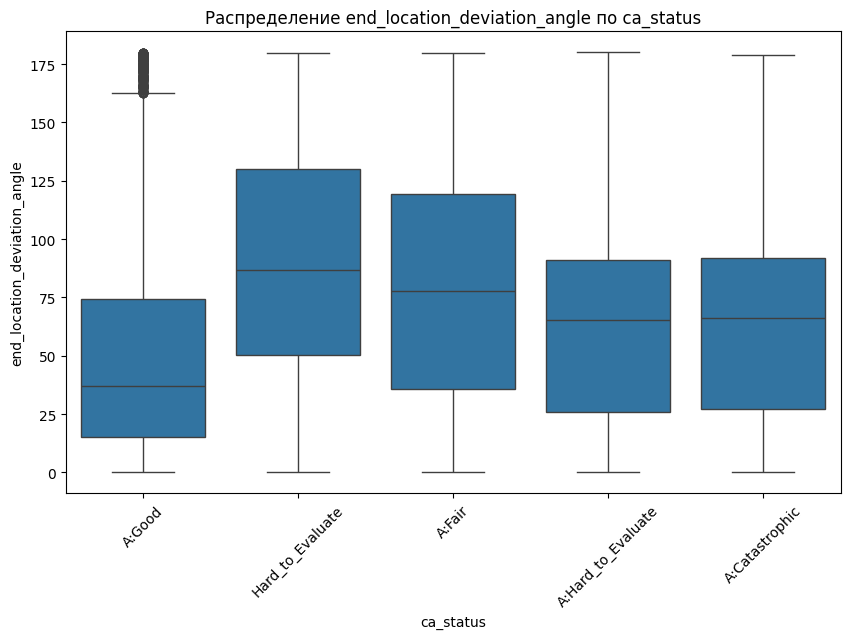

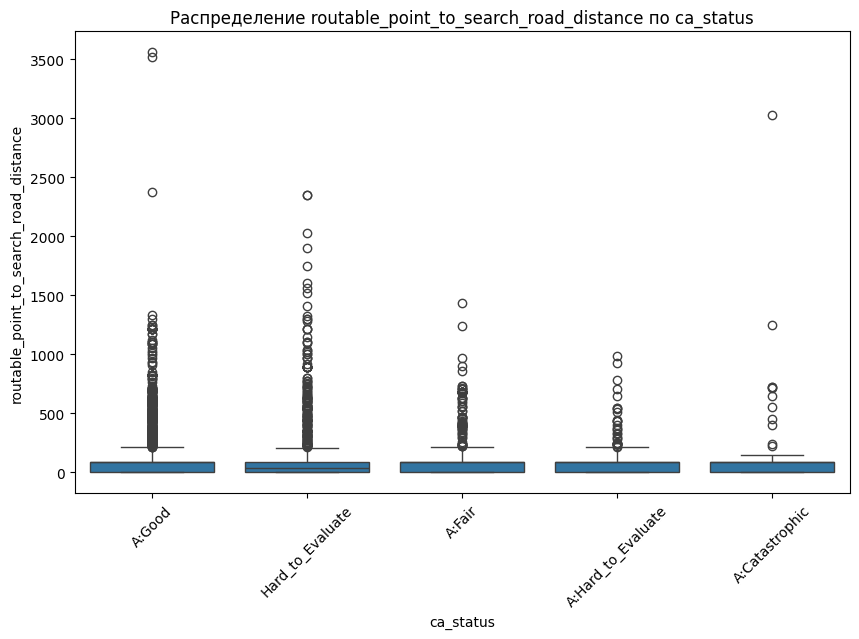

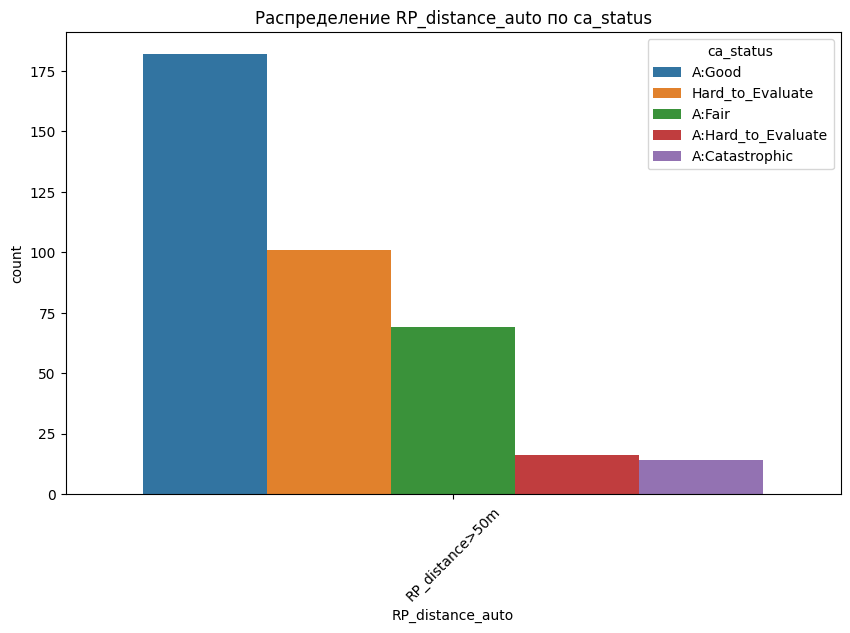

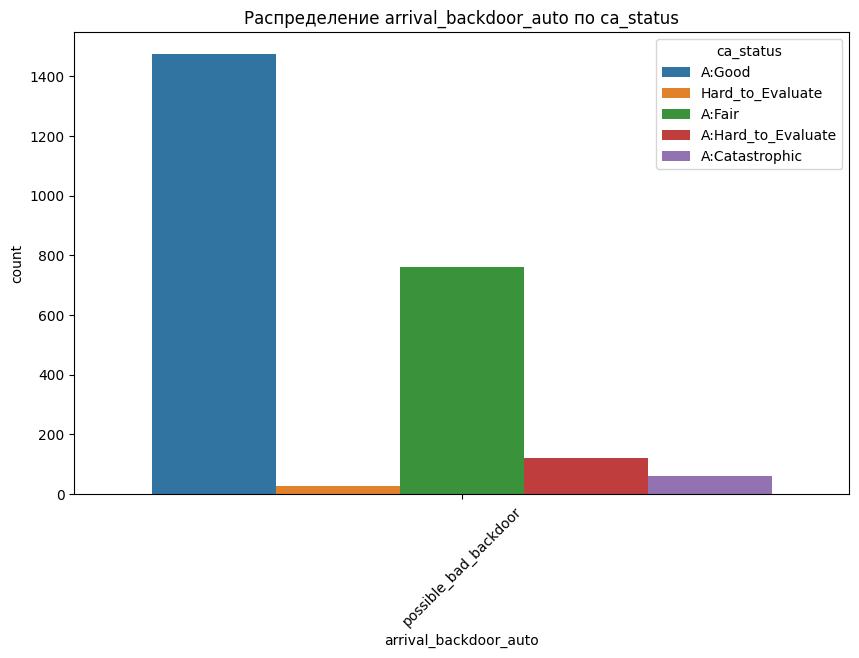

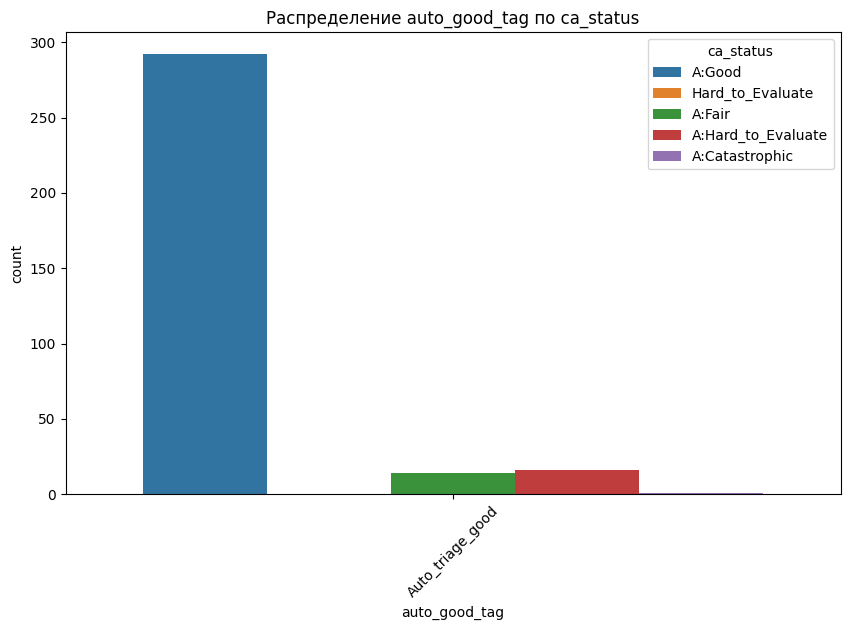

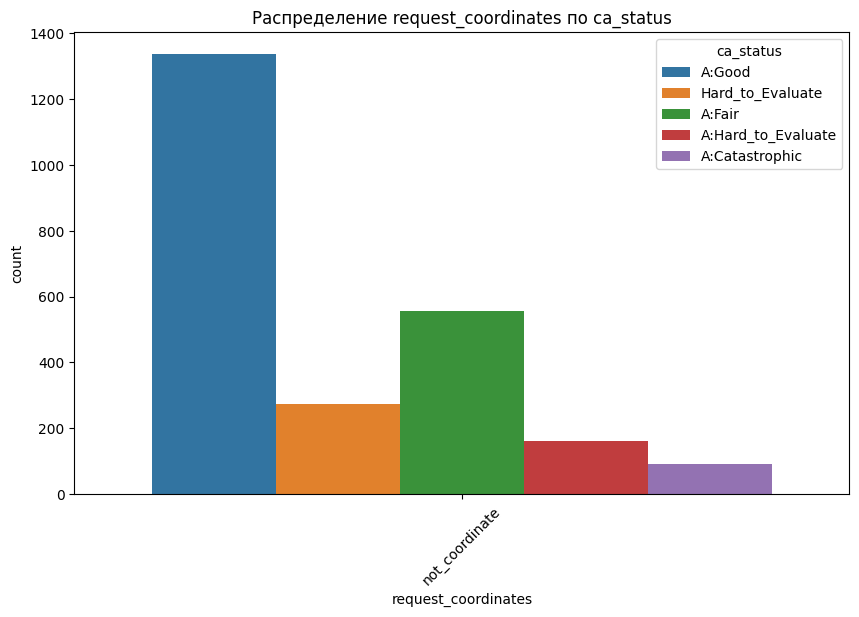

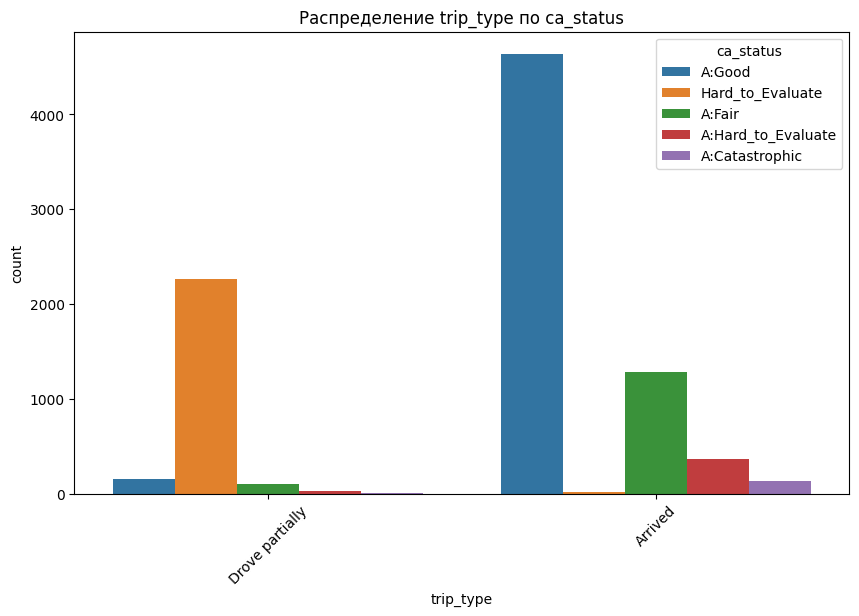

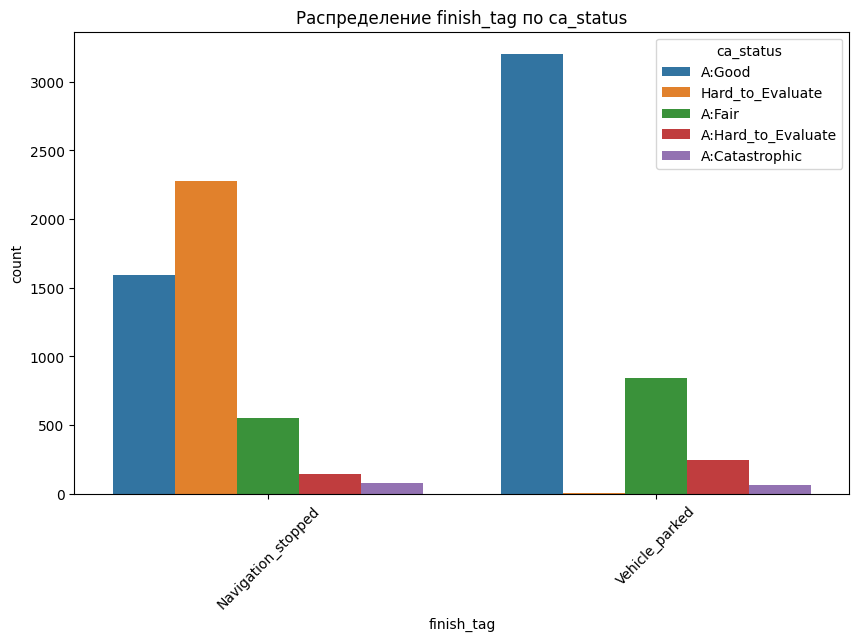

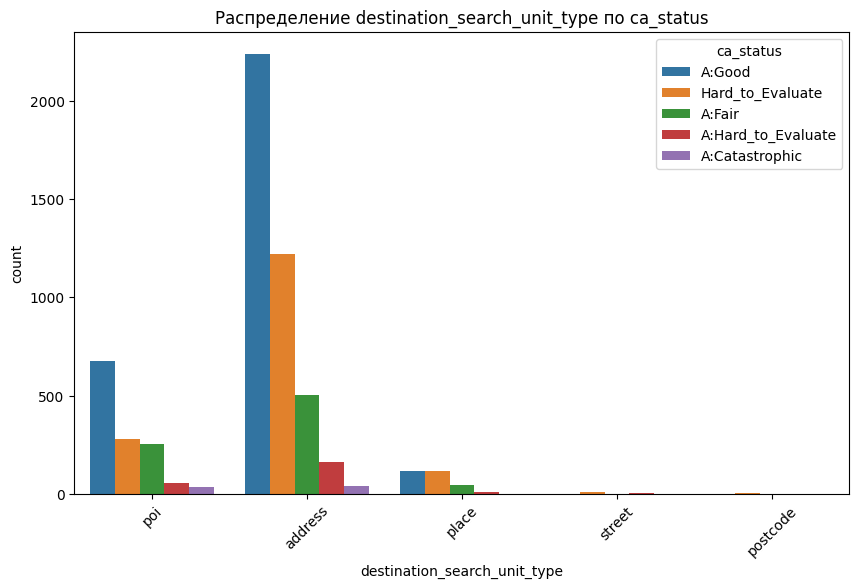

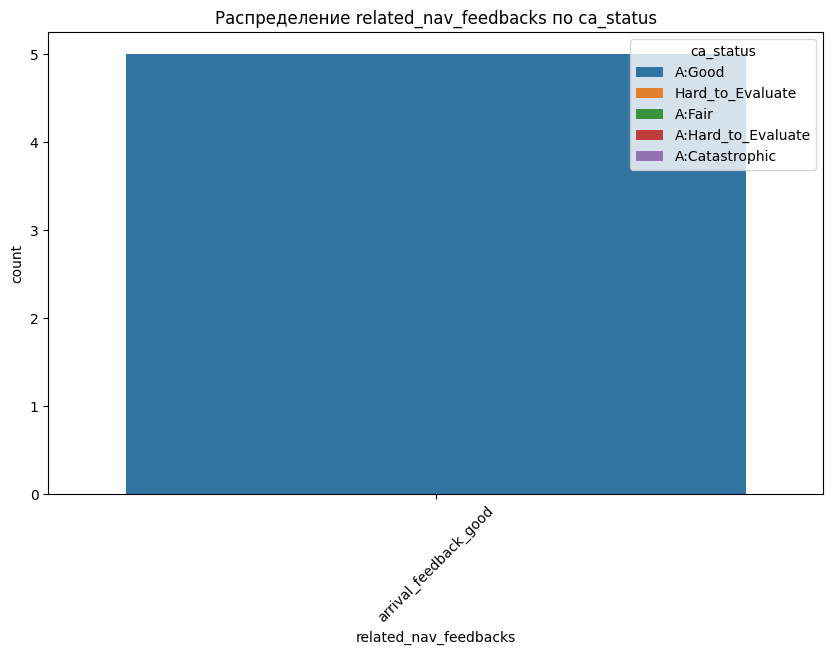

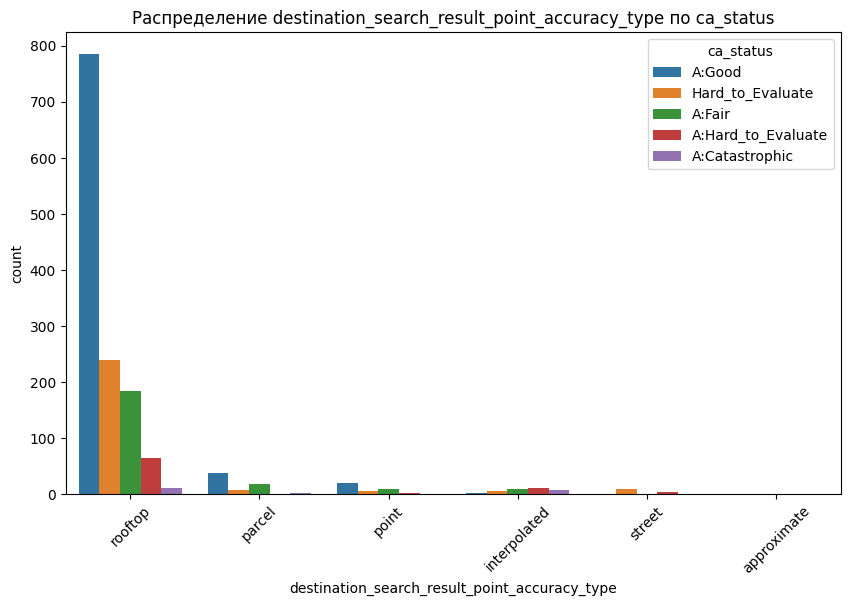

In [42]:
# ящики с усами

df = pd.read_csv('automation_issue.csv', index_col=None)

# Списки числовых 
numeric_features = [
    'search_events_count', 'difference_from_reroute',
    'original_estimated_duration', 'real_duration', 'gps_trace_duration',
    'reroute_count', 'destination_search_result_point_rang', 'end_location_deviation_angle',
    'routable_point_to_search_road_distance'
]
# и категориальных метрик
categorical_columns = [
    'RP_distance_auto', 'arrival_backdoor_auto', 'auto_good_tag', 'request_coordinates',
    'trip_type', 'finish_tag', 'destination_search_unit_type', 'related_nav_feedbacks',
    'destination_search_result_point_accuracy_type'
]

# Обработка пропусков
# Для числовых столбцов: заполняем средним
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean(numeric_only=True))

# Ящиковые диаграммы для числовых метрик
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ca_status', y=feature, data=df)
    plt.title(f'Распределение {feature} по ca_status')
    plt.xticks(rotation=45)
    plt.savefig(f'boxplot_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Графики распределения для категориальных метрик
for feature in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='ca_status', data=df)
    plt.title(f'Распределение {feature} по ca_status')
    plt.xticks(rotation=45)
    plt.savefig(f'countplot_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [43]:
# Загрузка данных
df = pd.read_csv('automation_issue.csv', index_col=None)

# Ограничение датасета нужными метриками
important_features = [
    'ca_status', 'difference_from_reroute', 'end_location_deviation_angle', 'reroute_count'
]
df = df[important_features]

# Обработка пропусков
df = df.fillna(df.mean(numeric_only=True))

# Функция для анализа порогов
def analyze_thresholds(feature, threshold, target_status, data):
    condition = data[feature] > threshold
    subset = data[condition]
    status_counts = subset['ca_status'].value_counts(normalize=True) * 100
    print(f"\nАнализ для {feature} > {threshold}:")
    print(status_counts)
    accuracy = status_counts.get(target_status, 0)
    print(f"Доля {target_status}: {accuracy:.2f}%")
    return accuracy

def analyze_thresholds2(feature, threshold, target_status, data):
    condition = data[feature] < threshold
    subset = data[condition]
    status_counts = subset['ca_status'].value_counts(normalize=True) * 100
    print(f"\nАнализ для {feature} < {threshold}:")
    print(status_counts)
    accuracy = status_counts.get(target_status, 0)
    print(f"Доля {target_status}: {accuracy:.2f}%")
    return accuracy

thresholds_diff_meters = [500, 800]
for thresh in thresholds_diff_meters:
    analyze_thresholds('difference_from_reroute', thresh, 'Hard_to_Evaluate', df)

thresholds_diff_meters = [24, 142]
for thresh in thresholds_diff_meters:
    analyze_thresholds2('difference_from_reroute', thresh, 'A:Good', df)

thresholds_reroute = [3, 4, 5]
for thresh in thresholds_reroute:
    analyze_thresholds('reroute_count', thresh, 'A:Catastrophic', df)

thresholds_reroute = [90, 100, 150, 170]
for thresh in thresholds_reroute:
    analyze_thresholds('end_location_deviation_angle', thresh, 'A:Catastrophic', df)


Анализ для difference_from_reroute > 500:
ca_status
Hard_to_Evaluate      97.948217
A:Good                 1.074744
A:Fair                 0.537372
A:Hard_to_Evaluate     0.341964
A:Catastrophic         0.097704
Name: proportion, dtype: float64
Доля Hard_to_Evaluate: 97.95%

Анализ для difference_from_reroute > 800:
ca_status
Hard_to_Evaluate      99.079589
A:Good                 0.433135
A:Hard_to_Evaluate     0.270709
A:Fair                 0.162426
A:Catastrophic         0.054142
Name: proportion, dtype: float64
Доля Hard_to_Evaluate: 99.08%

Анализ для difference_from_reroute < 24:
ca_status
A:Good                85.244704
A:Fair                 9.459459
A:Hard_to_Evaluate     4.273192
A:Catastrophic         0.949598
Hard_to_Evaluate       0.073046
Name: proportion, dtype: float64
Доля A:Good: 85.24%

Анализ для difference_from_reroute < 142:
ca_status
A:Good                73.346463
A:Fair                19.711144
A:Hard_to_Evaluate     5.054981
A:Catastrophic         1.690464
Ha

Качественные характеристики ботов: auto:triage-good, possible_bad_arrival_RP_distance, possible_bad_arrival_backdoor


Метрики для auto_good_tag:
TP: 4174
TN: 292
FP: 4506
FN: 31
Accuracy: 0.496
Precision: 0.904
Recall: 0.061
F1-score: 0.114


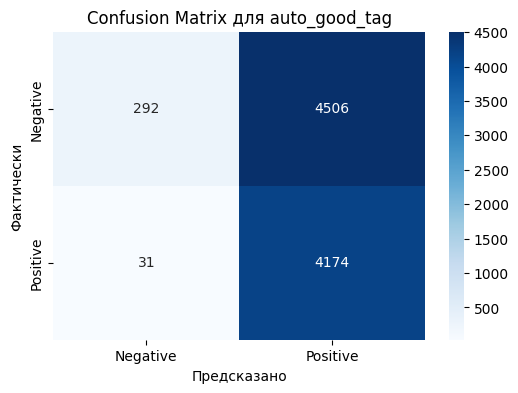


Метрики для possible_bad_arrival_RP_distance:
TP: 7763
TN: 62
FP: 858
FN: 320
Accuracy: 0.869
Precision: 0.162
Recall: 0.067
F1-score: 0.095


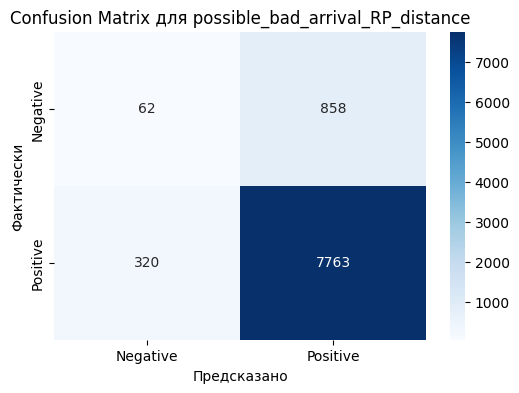


Метрики для possible_bad_arrival_backdoor:
TP: 6194
TN: 553
FP: 367
FN: 1889
Accuracy: 0.749
Precision: 0.226
Recall: 0.601
F1-score: 0.329


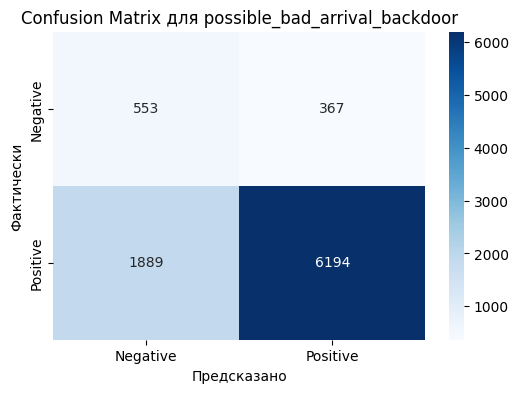

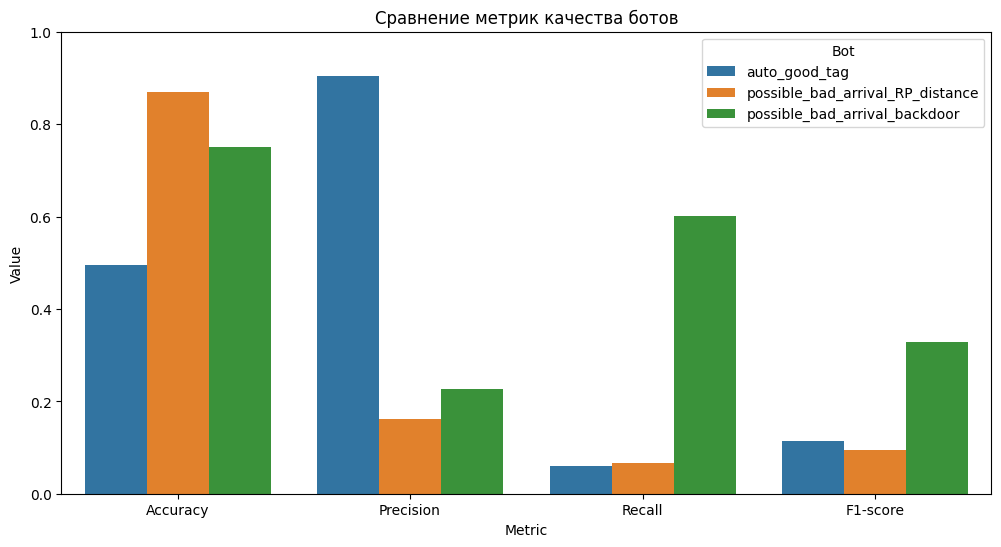

In [45]:
# Загрузка данных
df = pd.read_csv('automation_issue.csv', index_col=None)

# Обработка пропусков
df = df.fillna(df.mean(numeric_only=True))

# Функция для расчета TP, TN, FP, FN и метрик
def calculate_metrics(y_true, y_pred, bot_name):
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    tn, fp, fn, tp = cm.ravel()
    
    # Метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Вывод результатов
    print(f"\nМетрики для {bot_name}:")
    print(f"TP: {tp}")
    print(f"TN: {tn}")
    print(f"FP: {fp}")
    print(f"FN: {fn}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")
    
    # Визуализация confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix для {bot_name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Фактически')
    plt.savefig(f'confusion_matrix_{bot_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    return {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn, 
            'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# 1. auto_good_tag
# TP: auto_good_tag = Auto_triage_good и ca_status = A:Good
# TN: auto_good_tag ≠ Auto_triage_good и ca_status ≠ A:Good
# FP: auto_good_tag = Auto_triage_good и ca_status ≠ A:Good
# FN: auto_good_tag ≠ Auto_triage_good и ca_status = A:Good
y_true_good = (df['ca_status'] == 'A:Good').astype(int)
y_pred_good = (df['auto_good_tag'] == 'Auto_triage_good').astype(int)
metrics_good = calculate_metrics(y_true_good, y_pred_good, 'auto_good_tag')

# 2. possible_bad_arrival_RP_distance
# TP: RP_distance_auto = RP_distance>50m и (ca_status = A:Fair или A:Catastrophic) и RP = RP
# TN: RP_distance_auto ≠ RP_distance>50m и (ca_status ≠ A:Fair и ≠ A:Catastrophic или RP ≠ RP)
# FP: RP_distance_auto = RP_distance>50m и (ca_status ≠ A:Fair и ≠ A:Catastrophic или RP ≠ RP)
# FN: RP_distance_auto ≠ RP_distance>50m и (ca_status = A:Fair или A:Catastrophic) и RP = RP
y_true_rp = ((df['ca_status'].isin(['A:Fair', 'A:Catastrophic'])) & (df['RP'] == 'RP')).astype(int)
y_pred_rp = (df['RP_distance_auto'] == 'RP_distance>50m').astype(int)
metrics_rp = calculate_metrics(y_true_rp, y_pred_rp, 'possible_bad_arrival_RP_distance')

# 3. possible_bad_arrival_backdoor
# TP: arrival_backdoor_auto = possible_bad_backdoor и (ca_status = A:Fair или A:Catastrophic) и RP = RP
# TN: arrival_backdoor_auto ≠ possible_bad_backdoor и (ca_status ≠ A:Fair и ≠ A:Catastrophic или RP ≠ RP)
# FP: arrival_backdoor_auto = possible_bad_backdoor и (ca_status ≠ A:Fair и ≠ A:Catastrophic или RP ≠ RP)
# FN: arrival_backdoor_auto ≠ possible_bad_backdoor и (ca_status = A:Fair или A:Catastrophic) и RP = RP
y_true_backdoor = ((df['ca_status'].isin(['A:Fair', 'A:Catastrophic'])) & (df['RP'] == 'RP')).astype(int)
y_pred_backdoor = (df['arrival_backdoor_auto'] == 'possible_bad_backdoor').astype(int)
metrics_backdoor = calculate_metrics(y_true_backdoor, y_pred_backdoor, 'possible_bad_arrival_backdoor')

# Визуализация сводных метрик
plt.figure(figsize=(12, 6))
summary_metrics_melted = summary_metrics.melt(id_vars='Metric', 
                                             value_vars=['auto_good_tag', 'possible_bad_arrival_RP_distance', 'possible_bad_arrival_backdoor'],
                                             var_name='Bot', value_name='Value')
sns.barplot(data=summary_metrics_melted[summary_metrics_melted['Metric'].isin(['Accuracy', 'Precision', 'Recall', 'F1-score'])], 
            x='Metric', y='Value', hue='Bot')
plt.title('Сравнение метрик качества ботов')
plt.ylim(0, 1)
plt.savefig('bots_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()